In [1]:
## Import preliminary libaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

| Column Name           | Description                                                                                              |
|-----------------------|----------------------------------------------------------------------------------------------------------|
| date                  | Date in format dd/mm/yyyy                                                                               |
| time                  | Time in format hh:mm:ss                                                                                 |
| global_active_power   | Household global minute-averaged active power (in kilowatt)                                             |
| global_reactive_power | Household global minute-averaged reactive power (in kilowatt)                                           |
| voltage               | Minute-averaged voltage (in volt)                                                                       |
| global_intensity      | Household global minute-averaged current intensity (in ampere)                                          |
| sub_metering_1        | Energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered). |
| sub_metering_2        | Energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light. |
| sub_metering_3        | Energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner. |


In [110]:
energy_df = pd.read_csv('household_power_consumption.txt', 
                        delimiter=';',
                        #limit to 40,000 observations to make the loading faster for this demonstration
                        nrows=40000,
                        #Merge the date and time columns and convert it to datetime
                        parse_dates={'datetime': ['Date', 'Time']},
                        #force pandas to read the other variables as objects since there's a '?' in some of the columns
                        dtype={'Global_active_power': object, 'Global_reactive_power': object, 
                              'Voltage': object, 'Global_intensity': object, 
                              'Sub_metering_1': object, 'Sub_metering_2': object, 'Sub_metering_3': object})

In [111]:
energy_df.head()

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.000
1,2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.000
2,2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.000
3,2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.000
4,2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.000


In [112]:
energy_df = (energy_df
                 #set the datetime column as the index
                 .set_index('datetime')
                 #replace the culprit character with 'nothing'
                 .replace("?",None)
                 #convert the dtype of the variables except datetime to float from the object dtype 
                 .astype({col: float for col in energy_df.columns[1:]})
                 #drop the Global_reactive_power variable to make the prediction simpler
                 .drop(columns=['Global_reactive_power'])
                 #Resample the dataframe to aggregate and show the average of all the variables per hour
                 .resample('H').mean()
                 #rearrange the variables
                 .loc[:, ['Voltage', 'Global_intensity', 'Sub_metering_1','Sub_metering_2', 'Sub_metering_3', 'Global_active_power']]
                 #drop observations where all the variables are null values
                 .dropna(how='all', axis=0)                 
     
            )
energy_df.head()

,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Global_active_power
datetime,,,,,,
2006-12-16 17:00:00,234.643889,18.100000,0.0,0.527778,16.861111,4.222889
2006-12-16 18:00:00,234.580167,15.600000,0.0,6.716667,16.866667,3.632200
2006-12-16 19:00:00,233.232500,14.503333,0.0,1.433333,16.683333,3.400233
2006-12-16 20:00:00,234.071500,13.916667,0.0,0.000000,16.783333,3.268567
2006-12-16 21:00:00,237.158667,13.046667,0.0,0.416667,17.216667,3.056467


In [113]:
energy_df.isna().sum()

Voltage                0
Global_intensity       0
Sub_metering_1         0
Sub_metering_2         0
Sub_metering_3         0
Global_active_power    0
dtype: int64

In [114]:
energy_df.shape

(668, 6)

## EDA

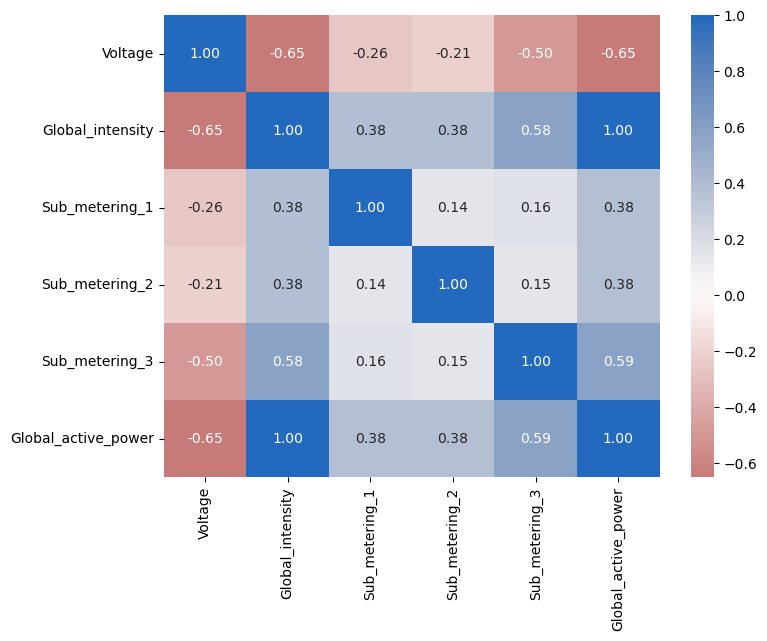

In [115]:
#Check Correlation between the variables
plt.figure(figsize = [8, 6])
sns.heatmap(energy_df.corr(), annot = True, fmt = '.2f',
           cmap = 'vlag_r', center = 0);

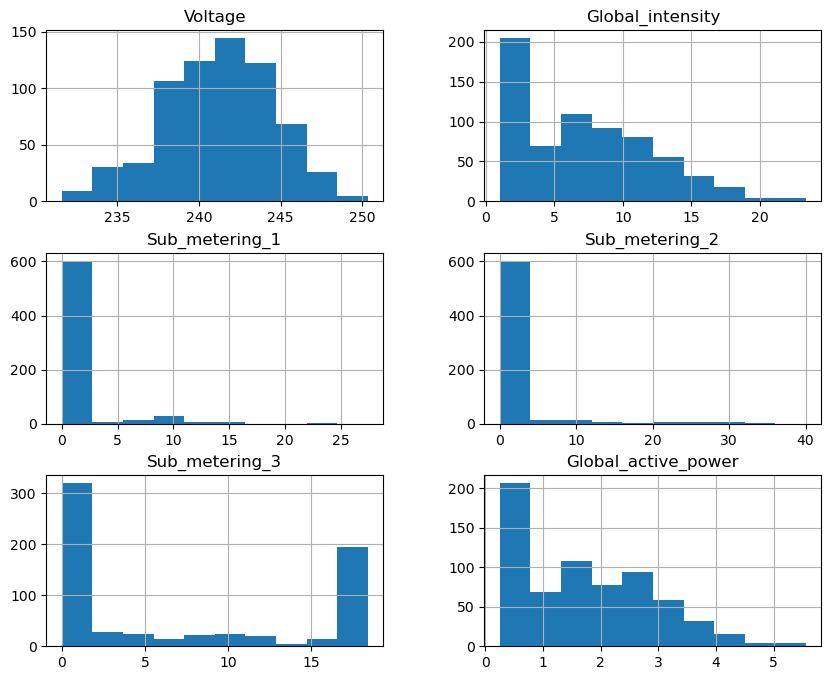

In [117]:
#Check Distribution
energy_df.hist(figsize= (10,8));

## Feature Engineering

In [109]:
energy_df['Metering_voltage_interaction'] = ((energy_df['Sub_metering_1'] +energy_df['Sub_metering_2']+\
                                              energy_df['Sub_metering_3'])/3)/energy_df.Voltage

## Split the dataset

In [92]:
# Calculate the index for the split point for the 80/20 split ratio
split_index = int(len(energy_df) * 0.8)

# Split the data into training and testing sets
train_data = energy_df.iloc[:split_index]
test_data = energy_df.iloc[split_index:]

# Verify the shapes of the training and testing sets
print('Training data shape:', train_data.shape)
print('Testing data shape:', test_data.shape)

# Extract the input features (X) and target variable (y) for the training set
X_train = train_data.drop('Global_active_power', axis=1)
y_train = train_data['Global_active_power']

# Extract the input features (X) and target variable (y) for the testing set
X_test = test_data.drop('Global_active_power', axis=1)
y_test = test_data['Global_active_power']

Training data shape: (534, 7)
Testing data shape: (134, 7)


## Implement the Model

In [102]:
from scipy.stats import randint
from sklearn.ensemble import RandomForestRegressor

# Create a random forest regressor with a set random state for reproducibility
regressor = RandomForestRegressor(random_state=42)

from sklearn.preprocessing import StandardScaler

# Use a standard scaler to scale all features to prevent bias
scaler = StandardScaler()

# Create a pipeline that scales features and applies the random forest regressor
from sklearn.pipeline import Pipeline
rfr_pipeline = Pipeline(steps=[('scaler', scaler),
                               ('rfr', regressor)])

# Specify the parameter grid for the randomized search cross-validation
param_grid = {
    'rfr__n_estimators': randint(50, 150), # Number of trees in the forest
    'rfr__max_depth': [3, 5, 7], # Maximum depth of each tree
    'rfr__max_features': ['sqrt', 'log2'], # Maximum number of features considered for splitting
    'rfr__min_samples_split': [2, 4, 6, 8, 10], # Minimum number of samples required to split an internal node
    'rfr__min_samples_leaf': [1, 2, 4] # Minimum number of samples required to be at a leaf node
}

# Create a scoring function using neg_mean_squared_error to be used in the randomized search
from sklearn.metrics import mean_squared_error, make_scorer
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Search for the best parameters using randomized search cross-validation
from sklearn.model_selection import RandomizedSearchCV
random_rfr = RandomizedSearchCV(rfr_pipeline, param_grid, cv=5, n_iter=100, n_jobs=-1, verbose=0, scoring=scorer) 

# Fit the model to the training data
random_rfr.fit(X_train, y_train)

# Print the best parameters that produce the best negative mean squared error
print("Best parameters:", random_rfr.best_params_)
print("Best score:", random_rfr.best_score_)    


Best parameters: {'rfr__max_depth': 7, 'rfr__max_features': 'sqrt', 'rfr__min_samples_leaf': 1, 'rfr__min_samples_split': 2, 'rfr__n_estimators': 100}
Best score: -0.050868250364630205


## Use the best parameters

In [104]:
best_model_rfr = random_rfr.best_estimator_
best_model_rfr.fit(X_train, y_train)

#Make Predictions on the test data
y_pred = best_model_rfr.predict(X_test)

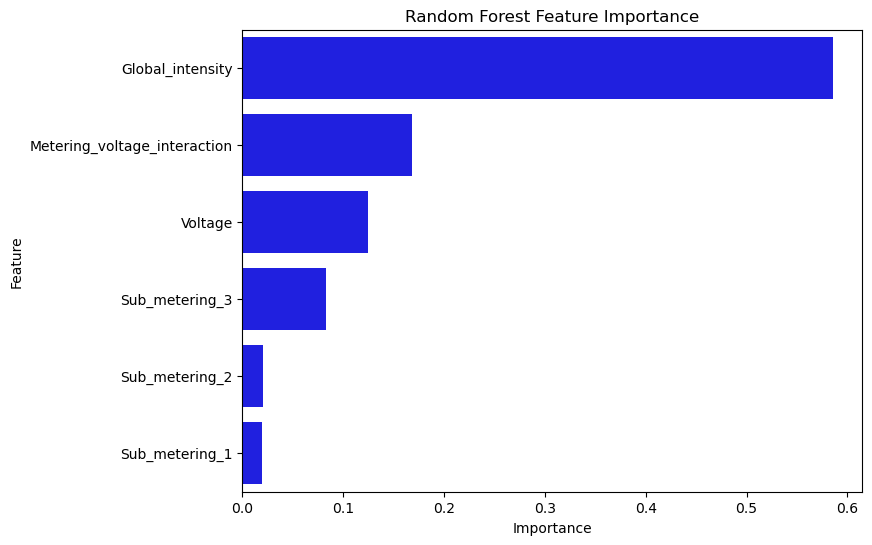

In [105]:
# Extract feature importance from the best model
importance = best_model_rfr.named_steps['rfr'].feature_importances_

# Create dataframe of feature importances and corresponding column names
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importance})

# Sort features by importance
feature_importances = feature_importances.sort_values(by=['Importance'], ascending=False)

# Plot feature importances
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances, color='b')
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature');

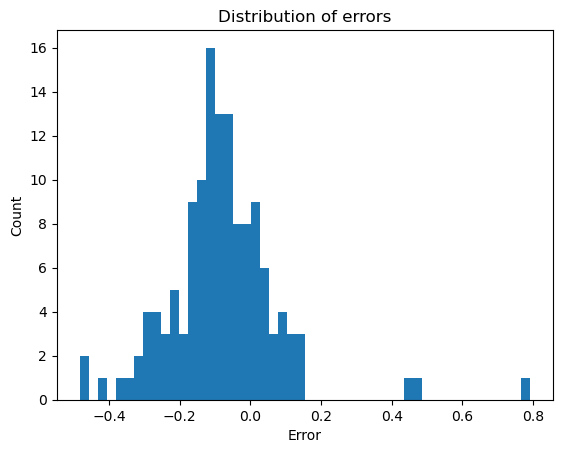

Mean squared error: 0.03
Root mean squared error: 0.18
Mean absolute error: 0.13
R-squared: 0.98


In [108]:
# Calculate the mean squared error and root mean squared error
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Calculate the mean absolute error
mae = mean_absolute_error(y_test, y_pred)

# Calculate the R-squared value
r2 = r2_score(y_test, y_pred)

# Plot the errors
errors = y_test - y_pred
plt.hist(errors, bins=50)
plt.xlabel('Error')
plt.ylabel('Count')
plt.title('Distribution of errors')
plt.show()

# Print the metrics
print(f'Mean squared error: {mse:.2f}')
print(f'Root mean squared error: {rmse:.2f}')
print(f'Mean absolute error: {mae:.2f}')
print(f'R-squared: {r2:.2f}')